In [69]:
import torch
from torchvision.ops import nms
from net import Net  # Importez la classe Net depuis votre fichier net.py
import torchvision.transforms as transforms
from PIL import Image

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [85]:
# Paramètres à faire varier
overlap = 0.7
threshold = 0.4
iou_threshold = 0.1

In [71]:
# Charger votre modèle pré-entraîné
model = Net()
model.load_state_dict(torch.load('model_new_archi.pth'))
model.eval()

# Taille d'entrée du réseau
window_size = 36

# Définir vos transformations pour les régions de la fenêtre
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# Charger votre image (à remplacer par l'image sur laquelle vous voulez effectuer la détection)
image = Image.open('images_sliding_window/image_visages_2.jpg')

# Convertir l'image en tenseur
image_tensor = transform(image)

# Obtenir les dimensions de l'image
img_width, img_height = image.size

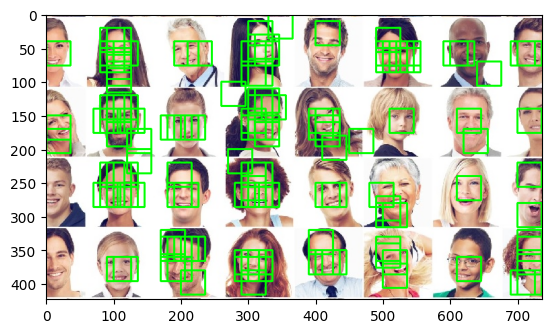

In [86]:
# Liste pour stocker les caractéristiques des fenêtres détectant des visages
detected_faces = []

# Liste pour stocker les scores de confiance des fenêtres détectant des visages
confidence_scores = []

# Nombre de visages détectés
nb_visages = 0

# Parcourir l'image avec la fenêtre coulissante
for y in range(0, img_height - window_size, int(window_size * (1 - overlap))):
    for x in range(0, img_width - window_size, int(window_size * (1 - overlap))):
        # Extraire la région de la fenêtre
        window = image_tensor[:, y:y+window_size, x:x+window_size].unsqueeze(0)  # Ajouter une dimension de lot

        # Faire la prédiction avec le modèle
        with torch.no_grad():
            output = model(window)
            output = torch.nn.functional.softmax(output, dim=1)

        # Si un visage est détecté, enregistrez ses caractéristiques
        if output[0,1] > threshold:
            detected_faces.append((x, y, x+window_size, y+window_size))
            confidence_scores.append(output[0,1])
            nb_visages += 1
        
# Afficher l'image avec les fenêtres détectant des visages
image_1 = np.array(image)
for x1, y1, x2, y2 in detected_faces:
    cv2.rectangle(image_1, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(image_1)
plt.show()

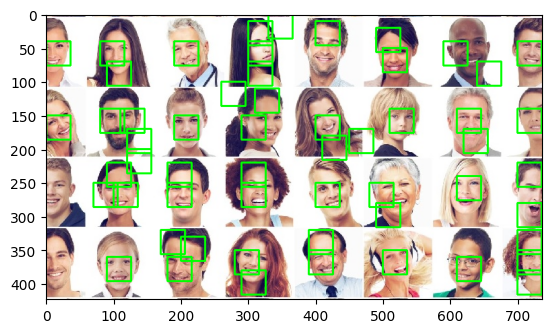

In [87]:
# Convertir les listes en tenseurs
boxes = torch.tensor(detected_faces, dtype=torch.float32)
confidence_scores = torch.tensor(confidence_scores, dtype=torch.float32)

# NMS
keep = nms(boxes, confidence_scores, iou_threshold)
filtered_boxes = boxes[keep]
filtered_boxes = filtered_boxes.numpy().astype(int)

# Afficher l'image avec les fenêtres détectant des visages
image_2 = np.array(image)
for x1, y1, x2, y2 in filtered_boxes:
    cv2.rectangle(image_2, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(image_2)
plt.show()

